### NGSA KAGGLE CHALLENGE : MISSING LINK PREDICTION

#### Team Name : Joel&Fatma&Joseph&Brice

In [1]:
import random
import numpy as np
import igraph
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk
import csv

## Chargement des fichiers et séparation train_test_split

In [2]:
with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]

with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]
y = [elt[-1] for elt in training_set]
y = np.array(y).astype(int)
with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]

In [3]:
## idée rajouter titre à l'abstract
corpus = [element[5] + ' ' + element[2].lower() for element in node_info]
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
#nltk.download('stopwords'); nltk.download('punkt'); nltk.download('wordnet')
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
def tokenize(text) :
    tokens = word_tokenize(text)
    result = [stemmer.stem(i) for i in tokens if((i.isalpha()) & (i not in stop_words)) ]
    return ' '.join(result)
## paralellisation de la lemmatisation des textes
from multiprocessing import Pool
with Pool(8) as p: 
    corpus_new = p.map(tokenize, corpus)

## création d'un dataframe pour stocker les informations des noeuds
dico_node_info = {elt[0]: {'pub_year': int(elt[1]), 'authors' : elt[3].split(','),
                                'abstract' : corpus_new[i].split()} for i, elt in enumerate(node_info)}

### Suppression volontaire de quelques liens pour valider le modèle

In [4]:
import pandas as pd
import warnings
warnings.simplefilter('ignore')
data_ = pd.DataFrame({'node_1':[int(elt[0]) for elt in training_set], 
                     'node_2':[int(elt[1]) for elt in training_set],
                    'link' : [int(elt[2]) for elt in training_set]})
#fb_df_temp = data_[data_.link == 1]
#fb_df_temp.link = 1 - fb_df_temp.link
#fb_df_temp.columns = ['node_2', 'node_1', 'link']

#data_ = data_.append(fb_df_temp)
import networkx as nx
import tqdm
fb_df_temp = data_[data_.link == 1]
initial_node_count = len(set(fb_df_temp.node_1.unique()).union(set(fb_df_temp.node_2.unique())))
# empty list to store removable links
omissible_links_index = []
for i in tqdm.tqdm(data_[data_.link == 1].index.values):
    break
    # remove a node pair and build a new graph
    tmp = fb_df_temp.drop(index = i) 
    all_nodes = set(tmp.node_1.unique()).union(set(tmp.node_2.unique()))
    if len(all_nodes) == initial_node_count :
        omissible_links_index.append(i)
        fb_df_temp = fb_df_temp.drop(index = i)        
    else :
        pass
    if len(omissible_links_index) == 15000 :
        break
#np.save('omissible.npy', omissible_links_index)
# omissible_links_index = np.load('omissible.npy')[:15000]
fb_df_partial = data_[data_.link == 1].drop(index = omissible_links_index).drop(columns=['link'])

  0%|          | 0/335130 [00:00<?, ?it/s]


In [5]:
all_nodes = set(fb_df_partial.node_1.unique()).union(set(fb_df_partial.node_2.unique()))
nodes_bizz = [node for node in dico_node_info.keys() if int(node) not in all_nodes]

In [23]:
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.DiGraph())
G_data.add_nodes_from(nodes_bizz)

In [7]:
len(G_data)

27770

In [8]:
all_pairs = [tuple(elt[:2]) for elt in np.array(training_set).astype(int)] +\
            [tuple(elt[:2]) for elt in np.array(testing_set).astype(int)]

In [9]:
pairs_train = [tuple(elt[0 : 2]) for i, elt in enumerate(training_set) if i not in omissible_links_index]
y_train = [int(elt[-1]) for i, elt in enumerate(training_set) if i not in omissible_links_index]
print('train : ', len(pairs_train))

pairs_val = [tuple(elt[0 : 2]) for i, elt in enumerate(training_set) if i in omissible_links_index]
y_val = np.array([int(elt[-1]) for i, elt in enumerate(training_set) if i in omissible_links_index])
print('val :', len(pairs_val))

y_train = np.array(y_train)
y_val = np.array(y_val)

train :  600512
val : 15000


## Extraction des features

### Working with attributes of nodes

In [10]:
### TF-IDF pour la similarité entre abstract + titre
vectorizer = TfidfVectorizer(decode_error='ignore', smooth_idf=False, stop_words=stop_words,
                      encoding='utf-8', min_df = 2, max_df=5000)
# each row is a node in the order of node_info
corpus_idf = vectorizer.fit_transform(corpus_new)
corpus_idf.shape

(27770, 8868)

In [11]:
## Etude du delta entre les années
tmp_ = pd.DataFrame.from_dict(dico_node_info).T[['pub_year', 'authors']]
tmp_['node_1'] = tmp_.index.astype(int)
tmp = pd.merge(tmp_, data_, on='node_1')
tmp = tmp.rename(columns = {"pub_year":"pub_year_1"})
tmp_ = tmp_.rename(columns = {"node_1":"node_2"})
tmp = pd.merge(tmp_, tmp, on='node_2')
tmp = tmp.rename(columns = {"pub_year":"pub_year_2"})
tmp['diff_year'] = tmp.pub_year_1 - tmp.pub_year_2
x = 100*( len(tmp[(tmp.diff_year < 0 ) & (tmp.link == 1)])/(tmp.diff_year < 0 ).sum() )
print(x, "% des delta years < 0 sont connectés")

1.6403697782720512 % des delta years < 0 sont connectés


In [12]:
## Doc Embedding of the abstracts
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_new)]
model = Doc2Vec(documents, vector_size=64, window=2, min_count=1, workers=7)
model.train(documents, total_examples=model.corpus_count, epochs=100)
fname ='doc2vec'
model.save(fname)
model = Doc2Vec.load(fname) 

In [13]:
abstr_embs = {} 
for source in tqdm.tqdm (dico_node_info.keys()) :
    abstr_embs[source] = model.infer_vector(dico_node_info[source]['abstract'])
def compute_similarity_emb(vector_s, vector_t):
    sim = np.dot(vector_s, vector_t)/(np.linalg.norm(vector_s)*np.linalg.norm(vector_t))
    return sim

100%|██████████| 27770/27770 [01:29<00:00, 309.56it/s]


In [14]:
def get_features(tuple_to_process) : 
    ret = []
    source = tuple_to_process[0]
    target = tuple_to_process[1]
    
    source_info = dico_node_info[source]
    target_info = dico_node_info[target]
    
    source_abstract = set(source_info['abstract'])
    target_abstract = set(target_info['abstract'])
    
    source_auth = set(source_info['authors'])
    target_auth = set(target_info['authors'])
    
    ## delta entre dates de publication
    delta_year = int(source_info['pub_year']) - int(target_info['pub_year'])
    
    ## cosine similiarity et intersection auteurs abstracts
    common_words = len(source_abstract.intersection(target_abstract))/(len(source_abstract.union(target_abstract)))
    common_auths = len(source_auth.intersection(target_auth))/(len(source_auth.union(target_auth)))
    
    cosine_sim = corpus_idf[IDs.index(source)].dot( 
                        corpus_idf[IDs.index(target)].T).toarray()[0][0] ## les vecteurs sont déjà normés 
    
    ret.append(common_words)
    ret.append(cosine_sim) ## tf-idf similarity
    ret.append(delta_year)
    ret.append(common_auths)
    ret.append(compute_similarity_emb(abstr_embs[source], abstr_embs[target]))
    
    return np.array(ret)

### features liées à la structure du graphe

In [15]:
def common_neighbors(G, ebunch = None):
    u = ebunch[0]
    v = ebunch[1]
    if str(u) in nodes_bizz :
        u = str(u)
    if str(v) in nodes_bizz :
        v = str(v)
    common_neighbors =  [w for w in G[u] if w in G[v] and w not in (u, v)]
    return common_neighbors

In [16]:
dico_common_neighbors = {}
for elt in tqdm.tqdm(all_pairs) :
    dico_common_neighbors[elt] = common_neighbors(G_data, elt)

100%|██████████| 648160/648160 [00:22<00:00, 29168.33it/s]


In [17]:
## Graph similarity measures
def resource_allocation_index(G, ebunch=None):
    if ebunch is None:
        ebunch = nx.non_edges(G)
    def predict(u, v):
        key_ =  (u, v)
        return sum(1 / G.degree(w) for w in dico_common_neighbors.get(key_, []))
    return predict(ebunch[0], ebunch[1])
def jaccard_coefficient(G, ebunch=None):
    if ebunch is None:
        ebunch = nx.non_edges(G)
    def predict(u, v):
        key_ =  (u, v)
        cnbors = list(dico_common_neighbors.get(key_,[]))
        union_size = len(set(G[u]) | set(G[v]))
        if union_size == 0:
            return 0
        else:
            return len(cnbors) / union_size    
    return predict(ebunch[0], ebunch[1])
import math
def adamic_adar_index(G, ebunch=None):
    if ebunch is None:
        ebunch = nx.non_edges(G)
  
    def predict(u, v):
        key_ =  (u, v)
        try : 
            return sum(1 / math.log(G.degree(w)) for w in dico_common_neighbors.get(key_, []))
        except :
            print("bizzare")
            return -1
  
    return predict(ebunch[0], ebunch[1])

In [24]:
## Shortest path
def shortest_path(source, target, G_data) :
    try :
        G_data.remove_edge(source, target)
        try : 
            ret = nx.shortest_path_length(G_data, source, target)
            G_data.add_edge(source, target)
            return ret
        except :
            G_data.add_edge(source, target)
            return 1000
    except :
        try : 
            ret = nx.shortest_path_length(G_data, source, target)
            return ret
        except :
            return 1000

In [25]:
### Centrality, page rank and HITS
out_degree_centrality =  nx.out_degree_centrality(G_data)
in_degree_centrality = nx.in_degree_centrality(G_data)
page_rank = nx.pagerank_scipy(G_data)
hub_score, authority_score = nx.hits(G_data)

In [26]:
import itertools
def get_graph_feature(tuple_to_process, G_data=G_data) :
    ret = []
    source = tuple_to_process[0]
    target = tuple_to_process[1]
    if source not in nodes_bizz :
        source = int(source)
    if target not in nodes_bizz :
        target = int(target)
    ebunch = (source, target)    
    ret.append(out_degree_centrality[source])
    ret.append(in_degree_centrality[target])
    ret.append(page_rank[target])
    ret.append(out_degree_centrality[source] * in_degree_centrality[target])
    ret.append(hub_score[source])
    ret.append(authority_score[target])
    try :
        cm = len(dico_common_neighbors.get(ebunch, []))/(len(G_data[source]) + len(G_data[target]))
    except :
        cm = 0
    ret.append(cm)
    ret.append(resource_allocation_index(G_data, ebunch))
    ret.append(jaccard_coefficient(G_data, ebunch))
    ret.append(adamic_adar_index(G_data, ebunch))
    ret.append(shortest_path(source , target, G_data))

    return np.array(ret)

In [27]:
with Pool(6) as p: 
    features_nodes = p.map(get_features, pairs_train)
features_nodes = np.array(features_nodes)

with Pool(6) as p: 
    train_tr = p.map(get_graph_feature, pairs_train )
train_tr = np.asarray(train_tr)

In [28]:
print(features_nodes.shape)
print(train_tr.shape)

(600512, 5)
(600512, 11)


In [29]:
with Pool(6) as p: 
    features_val = p.map(get_features, pairs_val)
features_val = np.array(features_val)

with Pool(6) as p: 
    val_tr = p.map(get_graph_feature, pairs_val)
val_tr = np.asarray(val_tr)

In [30]:
print(features_val.shape)
print(val_tr.shape)

(15000, 5)
(15000, 11)


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [32]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import sklearn
def train_logistic(train, val, c_inf=-1, c_up=2, n=20) : 
    logistic = linear_model.LogisticRegression()
    C = np.logspace(c_inf, c_up, n)
    params = dict(C=C, class_weight=['balanced'], solver=['lbfgs'])
    clf = GridSearchCV(logistic, params, cv=3, verbose=10, n_jobs = -1,  scoring='f1')
    clf.fit(train, y_train)
    y_pred = clf.predict(val)
    score = sklearn.metrics.f1_score(y_val, y_pred)
    print(score)
    return clf, score

In [33]:
# initialize basic SVM
def train_svm(train, val, c_inf=-1, c_up=2, n=5) : 
    classifier = svm.LinearSVC()
    C = np.logspace(c_inf, c_up, n)
    params = dict(C=C, class_weight=['balanced'])
    clf = GridSearchCV(classifier, params, cv=2, verbose=10, n_jobs = -1,  scoring='f1')
    clf.fit(train, y_train)
    y_pred = clf.predict(val)
    score = sklearn.metrics.f1_score(y_val, y_pred)
    print(score)
    return clf, score

In [34]:
## f-1 score
import tensorflow.keras.backend as K
import sklearn
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [35]:
dico_score = {}

### Avec uniquement les features graph

In [36]:
train = scaler.fit_transform(train_tr)
val = scaler.transform(val_tr)
print(train.shape, val.shape)

(600512, 11) (15000, 11)


In [37]:
## Logistic regression
clf, score = train_logistic(train, val, c_inf=2, c_up=3, n=10)
clf.best_params_
dico_score['graph_structure_logistic'] = score

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   30.6s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   32.3s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   38.1s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   38.7s finished


0.9215615788338486


In [38]:
## SVM
clf, score = train_svm(train, val)
print(clf.best_params_)
dico_score['graph_structure_svm'] = score

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.9min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.2min remaining:   56.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.9min finished


0.914655764986795
{'C': 3.1622776601683795, 'class_weight': 'balanced'}


In [40]:
## XGBOOST
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
params = {'subsample': 0.7,
 'reg_lambda': 1,
 'reg_alpha': 0.1,
 'n_estimators': 200,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'min_child_weight': 7,
 'max_depth': 30,
 'learning_rate': 0.1,
 'gamma': 0.1,
 'criterion': 'entropy',
 'colsample_bytree': 1,
 'colsample_bylevel': 0.7,
         'n_jobs':-1}
clf = XGBClassifier()
clf.set_params(**params)
clf.fit(train, y_train)
y_pred = clf.predict(val)
score = sklearn.metrics.f1_score(y_val, y_pred)
print(score)
dico_score['graph_structure_xgboost'] = score

0.9618658730708007


In [41]:
columns = ['out_deg', 'in_deg', 'page_rank','pref_att',
           'hub_score','authority', 'common_neighs', 'resource',
           'jaccard', 'adamic', 'shortest_path']
feature_importance = pd.DataFrame(clf.feature_importances_)
feature_importance = 100.0 * \
    (feature_importance / feature_importance.max())
feature_importance = pd.concat([pd.DataFrame(
    columns), feature_importance], axis=1, ignore_index=True)
feature_importance.columns = ['Variable', 'Importance']
feature_importance = feature_importance.sort_values(
    by='Importance', axis=0, ascending=False)
feature_importance

,Variable,Importance
10,shortest_path,100.000000
7,resource,49.721283
6,common_neighs,36.903740
8,jaccard,29.411633
9,adamic,5.706720
2,page_rank,3.162671
5,authority,1.972737
3,pref_att,1.938154
4,hub_score,1.897993
1,in_deg,1.599373


### Avec uniquement les attributs

In [42]:
train = scaler.fit_transform(features_nodes) #features_nodes #
val = scaler.transform(features_val) #features_val #
print(train.shape, val.shape)

(600512, 5) (15000, 5)


In [43]:
## Logistic regression
clf, score = train_logistic(train, val, c_inf=-1, c_up=1, n=30)
print(clf.best_params_)
dico_score['node_attribut_logistic'] = score

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed:   17.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.1s finished


0.8777495136914559
{'C': 0.30391953823131973, 'class_weight': 'balanced', 'solver': 'lbfgs'}


In [44]:
## SVM
clf, score = train_svm(train, val)
print(clf.best_params_)
dico_score['node_attribut_svm'] = score

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   52.5s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.8min remaining:   45.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.9min finished


0.8716289916124421
{'C': 17.78279410038923, 'class_weight': 'balanced'}


In [45]:
## XGBOOST
clf = XGBClassifier()
clf.set_params(**params)
clf.fit(train, y_train)
y_pred = clf.predict(val)
score = sklearn.metrics.f1_score(y_val, y_pred)
print(score)
dico_score['node_attribut_xgboost'] = score

0.9214064859423311


In [46]:
columns_attr = ['common_words', 'common_authors', 'tf_idf_cosine', 'diff_year', 'doc2vec_cosine']
feature_importance = pd.DataFrame(clf.feature_importances_)
feature_importance = 100.0 * \
    (feature_importance / feature_importance.max())
feature_importance = pd.concat([pd.DataFrame(
    columns_attr), feature_importance], axis=1, ignore_index=True)
feature_importance.columns = ['Variable', 'Importance']
feature_importance = feature_importance.sort_values(
    by='Importance', axis=0, ascending=False)
feature_importance

,Variable,Importance
2,tf_idf_cosine,100.000000
1,common_authors,46.640224
3,diff_year,34.547367
0,common_words,14.835013
4,doc2vec_cosine,9.219380


### En concatenant les deux

In [47]:
train = np.hstack((train_tr, features_nodes))
val = np.hstack((val_tr, features_val))
train = scaler.fit_transform(train)
val = scaler.transform(val)
print(train.shape, val.shape)

(600512, 16) (15000, 16)


#### Regression logistic

In [48]:
clf, score = train_logistic(train, val, c_inf=1, c_up=3, n=10)
print(clf.best_params_)
dico_score['graph_attribut_logistic'] = score

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   35.6s remaining:   20.6s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   37.1s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   44.4s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   44.9s finished


0.9573196162936187
{'C': 10.0, 'class_weight': 'balanced', 'solver': 'lbfgs'}


#### SVM

In [49]:
clf, score = train_svm(train, val)
print(clf.best_params_)
dico_score['node_attribut_svm'] = score

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.5min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.1min remaining:   52.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.8min finished


0.9556135770234987
{'C': 17.78279410038923, 'class_weight': 'balanced'}


#### xgboost

In [50]:
clf = XGBClassifier()
clf.set_params(**params)
clf.fit(train, y_train)
y_pred = clf.predict(val)
score = sklearn.metrics.f1_score(y_val, y_pred)
print(score)
dico_score['graph_attribut_xgboost'] = score
feature_importance = pd.DataFrame(clf.feature_importances_)
feature_importance = 100.0 * \
    (feature_importance / feature_importance.max())
feature_importance = pd.concat([pd.DataFrame(
    columns + columns_attr), feature_importance], axis=1, ignore_index=True)
feature_importance.columns = ['Variable', 'Importance']
feature_importance = feature_importance.sort_values(
    by='Importance', axis=0, ascending=False)
feature_importance

0.9722507708119219


,Variable,Importance
10,shortest_path,100.000000
6,common_neighs,42.303875
7,resource,39.663643
9,adamic,12.495809
8,jaccard,8.823529
13,tf_idf_cosine,6.119644
12,common_authors,3.851392
14,diff_year,3.079254
2,page_rank,1.465281
3,pref_att,1.279755


#### Neural network

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Input, BatchNormalization
from tensorflow.core.protobuf import rewriter_config_pb2
import tensorflow.keras.backend as K
tf.keras.backend.clear_session()  # For easy reset of notebook state.
model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[f1_m])
bs = 4096
n_epochs = 30
history = model.fit(train, np.array(y_train),
                    batch_size=bs, epochs=n_epochs,
                    validation_data=(val, np.array(y_val)))
y_pred = model.predict(val)
y_pred = np.where(y_pred > 0.5, 1, 0)
score = sklearn.metrics.f1_score(y_val, y_pred)
print(score)
dico_score['graph_attribut_neural_network'] = score

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 600512 samples, validate on 15000 samples
Epoch 1/30
600512/600512 [==============================] - 2s 3us/sample - loss: 0.2803 - f1_m: 0.9058 - val_loss: 0.1632 - val_f1_m: 0.9640
Epoch 2/30
600512/600512 [==============================] - 1s 2us/sample - loss: 0.1656 - f1_m: 0.9435 - val_loss: 0.1433 - val_f1_m: 0.9705
Epoch 3/30
600512/600512 [==============================] - 1s 2us/sample - loss: 0.1508 - f1_m: 0.9483 - val_loss: 0.1332 - val_f1_m: 0.9730
Epoch 4/30
600512/600512 [==============================] - 1s 2us/sample - loss: 0.1451 - f1_m: 0.9501 - val_loss: 0.1241 - val_f1_m: 0.9755
Epoch 5/30
600512/600512 [==============================] - 1s 2us/sample - loss: 0.1423 - f1_m: 0.9510 - val_loss: 0.1283 - val_f1_m: 0.9743
Epoch 6/30
600512/600512 [=

## Graph embedding

### Node embeddings + NN

In [52]:
# entrainement du Node2Vec
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())
G_data.add_nodes_from(nodes_bizz)

from node2vec import Node2Vec
node2vec = Node2Vec(G_data, dimensions=128, walk_length=30, 
                    num_walks=30, workers=1, temp_folder='')
# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)
n2w_model.wv.save_word2vec_format('node_emb_partiel')

In [53]:
## chargement du modèle
from gensim.models import KeyedVectors
n2w_model = KeyedVectors.load_word2vec_format('node_emb_partiel', binary=False)

In [54]:
def get_node_emb(data) :
    node_emb = []
    for i, j in zip(data['node_1'], data['node_2']) :
        if i in G_data.nodes():
            emb_i = n2w_model.wv[str(i)]
        else :
            emb_i = np.zeros(128)
        if j in G_data.nodes():
            emb_j = n2w_model.wv[str(j)]
        else :
            emb_j = np.zeros(128)
        node_emb.append(np.hstack((emb_i, emb_j)))
    node_emb = np.asarray(node_emb)
    return node_emb )
node_emb = get_node_emb(data_.drop(index = omissible_links_index))

In [55]:
node_emb.shape

(600512, 256)

In [56]:
# ## Validation sur les noeuds omis !!
omitted_links = data_[data_.link == 1].iloc[omissible_links_index]
omitted_emb = get_node_emb(omitted_links)

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.core.protobuf import rewriter_config_pb2
import tensorflow.keras.backend as K

### Training only on node embedding

In [94]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.
model = Sequential()
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[f1_m])
bs = 10000
n_epochs = 50
history = model.fit(node_emb, y_train,
                    batch_size=bs, epochs=n_epochs,
                    validation_data=(omitted_emb, y_val))
y_pred = model.predict(omitted_emb)
y_pred = np.where(y_pred >0.5, 1, 0)
score = sklearn.metrics.f1_score(y_val, y_pred)
print(score)
dico_score['node2vec_alone_neural_network'] = score

Train on 600512 samples, validate on 15000 samples
Epoch 1/50
600512/600512 [==============================] - 14s 23us/sample - loss: 0.3644 - f1_m: 0.8293 - val_loss: 0.0640 - val_f1_m: 0.9897
Epoch 2/50
600512/600512 [==============================] - 13s 22us/sample - loss: 0.0845 - f1_m: 0.9766 - val_loss: 0.0308 - val_f1_m: 0.9953
Epoch 3/50
600512/600512 [==============================] - 14s 23us/sample - loss: 0.0501 - f1_m: 0.9868 - val_loss: 0.0205 - val_f1_m: 0.9973
Epoch 4/50
600512/600512 [==============================] - 12s 21us/sample - loss: 0.0388 - f1_m: 0.9900 - val_loss: 0.0194 - val_f1_m: 0.9969
Epoch 5/50
600512/600512 [==============================] - 14s 24us/sample - loss: 0.0331 - f1_m: 0.9916 - val_loss: 0.0137 - val_f1_m: 0.9982
Epoch 6/50
600512/600512 [==============================] - 15s 25us/sample - loss: 0.0284 - f1_m: 0.9929 - val_loss: 0.0127 - val_f1_m: 0.9981
Epoch 7/50
600512/600512 [==============================] - 13s 22us/sample - loss: 0

### Training on node embedding + graph structure + nodes attributs

In [59]:
x_train = np.hstack([node_emb, train])
x_val = np.hstack([omitted_emb, val])

#### Classic neural network with the concatenated features

In [60]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.
model = Sequential()
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[f1_m])
bs = 10000
n_epochs = 30
history = model.fit(x_train, y_train,
                    batch_size=bs, epochs=n_epochs,
                    validation_data=(x_val, y_val))
y_pred = model.predict(x_val)
y_pred = np.where(y_pred >0.5, 1, 0)
score = sklearn.metrics.f1_score(y_val, y_pred)
print(score)
dico_score['all_features_neural_network_1'] = score

Train on 600512 samples, validate on 15000 samples
Epoch 1/30
600512/600512 [==============================] - 13s 22us/sample - loss: 0.1809 - f1_m: 0.9311 - val_loss: 0.0264 - val_f1_m: 0.9960
Epoch 2/30
600512/600512 [==============================] - 10s 17us/sample - loss: 0.0517 - f1_m: 0.9846 - val_loss: 0.0171 - val_f1_m: 0.9977
Epoch 3/30
600512/600512 [==============================] - 11s 18us/sample - loss: 0.0365 - f1_m: 0.9894 - val_loss: 0.0175 - val_f1_m: 0.9979
Epoch 4/30
600512/600512 [==============================] - 11s 18us/sample - loss: 0.0284 - f1_m: 0.9917 - val_loss: 0.0095 - val_f1_m: 0.9984
Epoch 5/30
600512/600512 [==============================] - 11s 18us/sample - loss: 0.0220 - f1_m: 0.9937 - val_loss: 0.0122 - val_f1_m: 0.9980
Epoch 6/30
600512/600512 [==============================] - 11s 18us/sample - loss: 0.0194 - f1_m: 0.9944 - val_loss: 0.0119 - val_f1_m: 0.9981
Epoch 7/30
600512/600512 [==============================] - 11s 18us/sample - loss: 0

### Update neural network 

In [90]:
#Input image
input_emb = Input(shape=(256,))
input_attr = Input(shape=(16,))

encoded_1 = Dense(units=1024, activation='relu')(input_emb)
encoded_1 = Dropout(0.1)(encoded_1)
encoded_2 = Dense(units=256, activation='relu')(encoded_1)
encoded_2 = Dropout(0.1)(encoded_2)
encoded_2 = Dense(units=64, activation='relu')(encoded_2)
encoded_2 = Dropout(0.1)(encoded_2)
encoded = Concatenate()([encoded_2, input_attr])
output = Dense(units=16, activation='relu')(encoded)
output = Dropout(0.1)(output)
output = Dense(units=1, activation='sigmoid', name='autoencoder')(output)

autoencoder = Model(inputs = [input_emb, input_attr], outputs = output)
autoencoder.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics= [f1_m])

history = autoencoder.fit([node_emb, train], y_train,
                epochs=40,
                batch_size=10000,
                validation_data=([omitted_emb, val], y_val))
y_pred = autoencoder.predict([omitted_emb, val])[:, 0]
y_pred = np.where(y_pred >0.5, 1, 0)
score = sklearn.metrics.f1_score(y_val, y_pred)
print(score)
dico_score['all_features_neural_network_2'] = score

Train on 600512 samples, validate on 15000 samples
Epoch 1/40
600512/600512 [==============================] - 18s 29us/sample - loss: 0.2691 - f1_m: 0.8870 - val_loss: 0.0448 - val_f1_m: 0.9924
Epoch 2/40
600512/600512 [==============================] - 17s 28us/sample - loss: 0.0558 - f1_m: 0.9841 - val_loss: 0.0248 - val_f1_m: 0.9966
Epoch 3/40
600512/600512 [==============================] - 18s 29us/sample - loss: 0.0376 - f1_m: 0.9895 - val_loss: 0.0157 - val_f1_m: 0.9981
Epoch 4/40
600512/600512 [==============================] - 16s 27us/sample - loss: 0.0294 - f1_m: 0.9917 - val_loss: 0.0086 - val_f1_m: 0.9987
Epoch 5/40
600512/600512 [==============================] - 16s 27us/sample - loss: 0.0248 - f1_m: 0.9929 - val_loss: 0.0068 - val_f1_m: 0.9994
Epoch 6/40
600512/600512 [==============================] - 17s 28us/sample - loss: 0.0215 - f1_m: 0.9939 - val_loss: 0.0079 - val_f1_m: 0.9991
Epoch 7/40
600512/600512 [==============================] - 17s 28us/sample - loss: 0

(0.877, 1.01)

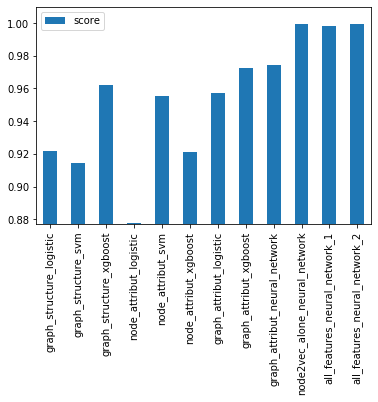

In [92]:
import matplotlib.pyplot as plt
scores = pd.DataFrame.from_dict(dico_score, orient='index')
scores.columns = ['score']
scores.plot(kind='bar');
plt.ylim(0.877, 1.01)

In [95]:
np.save('scores', scores)
scores.sort_values(by = 'score', ascending=False)

,score
all_features_neural_network_2,0.999566
node2vec_alone_neural_network,0.999333
all_features_neural_network_1,0.998197
graph_attribut_neural_network,0.974219
graph_attribut_xgboost,0.972251
graph_structure_xgboost,0.961866
graph_attribut_logistic,0.957320
node_attribut_svm,0.955614
graph_structure_logistic,0.921562
node_attribut_xgboost,0.921406


## Prédiction sur les données test

In [63]:
data_test = pd.DataFrame({'node_1':[int(elt[0]) for elt in testing_set], 
                     'node_2':[int(elt[1]) for elt in testing_set]})
emb_test = get_node_emb(data_test)

In [64]:
pairs_test = [tuple(elt[0 : 2]) for elt in testing_set]
with Pool(4) as p: 
    features_test = p.map(get_features, pairs_test)
features_test = np.array(features_test)
test_tr = []
for elt in tqdm.tqdm(pairs_test) :
    test_tr.append(get_graph_feature(elt))
test_tr = np.asarray(test_tr)

100%|██████████| 32648/32648 [00:29<00:00, 1119.95it/s]


In [65]:
# print(train.shape, test.shape)
test = np.hstack((test_tr, features_test))
test = scaler.transform(test)
x_test = np.hstack([emb_test, test])
y_test = model.predict(x_test)[:, 0]
y_test_1 = np.where(y_test > 0.5, 1, 0)

In [66]:
## prédiction sur le test
test = np.hstack((test_tr, features_test))
test = scaler.transform(test)
print(train.shape, test.shape)
y_test = autoencoder.predict([emb_test, test])[:, 0]
y_test_2 = np.where(y_test > 0.5, 1, 0)

(600512, 16) (32648, 16)


In [67]:
## Sauvegarde des prédictions
predictions_SVM = zip(range(len(testing_set)), y_test_1)
with open("predictions_1.csv","w") as pred1:
    csv_out = csv.writer(pred1)
    csv_out.writerow(('id', 'category'))
    for row in predictions_SVM:
        csv_out.writerow(row)

In [68]:
predictions_SVM = zip(range(len(testing_set)), y_test_2)
with open("predictions_2.csv","w") as pred1:
    csv_out = csv.writer(pred1)
    csv_out.writerow(('id', 'category'))
    for row in predictions_SVM:
        csv_out.writerow(row)